# LSTM implementation for the centralized model 

In [80]:
# Dataset - 2019
# Imputation tech - KNN for both air pollutants and meteorological data
# Evaluation metric - MAE while training and SMAPE metric for validating test data
# Negative values where not replaced

In [81]:
import os
import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [82]:
from numpy import split
from numpy import array

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM,GRU,Conv2D,MaxPool1D,Conv1D,MaxPooling1D,AveragePooling1D
from keras.layers import Bidirectional
from keras.layers import TimeDistributed,Dropout,RepeatVector

In [83]:
#Read the dataset based on the station id
# path = "Uppsala\\Sem 3\\Dataset\\2014-2018_combined\\18644\\KNN_18644_2015_2018.xlsx" 
# path = "output_Gade_Weather.csv"
# path = "Aalborg_Gade_Weather_finalMoreData.csv"
path = "Aalborg_Gade_Weather_finalMoreData.csv"

df_data = pd.read_csv(path)
# file_name = os.path.join("C:\\",path)


# df_2015_2019_data = pd.read_excel(file_name)

# df_2015_2019_data
df_data

,Start,NO2,NOx,heat_index,rh,pressure,wdir,wdir_cardinal,wspd,station_id
0,2019-12-06 10:00:00,11.84,18.23,9.0,87.0,992.65,260.0,W,31.0,Gade
1,2019-12-06 10:30:00,17.29,26.09,9.0,87.0,993.65,260.0,W,33.0,Gade
2,2019-12-06 11:00:00,21.40,31.80,8.0,93.0,993.65,250.0,WSW,33.0,Gade
3,2019-12-06 11:30:00,16.03,28.80,8.0,93.0,993.65,250.0,WSW,30.0,Gade
4,2019-12-06 12:00:00,25.11,38.67,8.0,93.0,993.65,250.0,WSW,24.0,Gade
...,...,...,...,...,...,...,...,...,...,...
39457,2022-03-07 10:30:00,19.83,33.64,-1.0,100.0,1026.63,230.0,SW,7.0,Gade
39458,2022-03-07 11:00:00,18.32,31.36,2.0,93.0,1026.63,230.0,SW,13.0,Gade
39459,2022-03-07 11:30:00,20.79,33.76,2.0,100.0,1026.63,240.0,WSW,17.0,Gade
39460,2022-03-07 12:00:00,17.12,28.67,2.0,100.0,1026.63,260.0,W,17.0,Gade


In [84]:
# Dropping some weather features, adding time features and converting them into one-hot encoded values

df = df_data.copy()
#Keeping heat index and relative humidity features
# df = df.drop(columns=['pressure', 'wdir', 'wdir_cardinal', 'wspd', 'station_id'])
df = df.drop(columns=['wdir_cardinal','station_id'])

lstm_df = df.copy()

# Add time related features
lstm_df['Weekday'] = pd.to_datetime(df['Start']).dt.day_name()
lstm_df['Hour'] = pd.to_datetime(df['Start']).dt.hour
# lstm_df['Minutes'] = pd.to_datetime(df['Start']).dt.minute


label_encoder_1 = LabelEncoder()
onehot_encoder_1 = OneHotEncoder(sparse=False)

integer_encoded = label_encoder_1.fit_transform(lstm_df['Weekday'])
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
lstm_df['Weekday'] = onehot_encoder_1.fit_transform(integer_encoded)

integer_encoded = label_encoder_1.fit_transform(lstm_df['Hour'])
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
lstm_df['Hour'] = onehot_encoder_1.fit_transform(integer_encoded)

# integer_encoded = label_encoder_1.fit_transform(lstm_df['Minutes'])
# integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
# lstm_df['Minutes'] = onehot_encoder_1.fit_transform(integer_encoded)

# Remove timestamp attribute
date_time = lstm_df.pop('Start')

# Replacing negative values with zeros
#lstm_df.PM10=lstm_df.PM10.mask(lstm_df.PM10.lt(0),0)

# Use first 9 months for training and validation sets for 2019
# train_data = lstm_df[0:41616] #lstm_df[0:24072] #train_data = lstm_df[0:6552]
train_data = lstm_df[0:35520] #lstm_df[0:30432] #lstm_df[0:24072] #train_data = lstm_df[0:6552]

# train_df = train_data[0:32856] #train_data[0:35064] #train_data[0:19680] #train_data[0:5088] # Training set - January - August months
# val_df = train_data[32856:] #train_data[35064:] #train_data[19680:] #train_data[5088:] # Validation set - September month
train_df = train_data[0:31968] #train_data[0:24336] #train_data[0:35064] #train_data[0:19680] #train_data[0:5088] # Training set - January - August months
val_df = train_data[31968:]  #train_data[24336:] #train_data[35064:] #train_data[19680:] #train_data[5088:] # Validation set - September month

# Use Oct-Dec months for Testing set
test_df = lstm_df[35520: -6] #lstm_df[24072:] #lstm_df[6552:]

num_features = lstm_df.shape[1]

In [85]:
lstm_df.shape

(39462, 9)

In [86]:
lstm_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NO2,39462.0,16.672865,11.822424,0.00,6.92,13.41,24.770,55.42
NOx,39462.0,34.371460,31.702481,0.00,10.50,21.93,51.755,212.63
heat_index,39462.0,8.732553,6.472370,-13.00,4.00,8.00,14.000,30.00
rh,39462.0,83.350109,14.995676,25.00,76.00,87.00,93.000,100.00
pressure,39462.0,1011.350680,11.972571,964.66,1003.64,1012.64,1019.640,1041.63
wdir,39462.0,200.611981,87.455915,10.00,130.00,220.00,270.000,360.00
wspd,39462.0,17.432593,10.393237,0.00,9.00,17.00,24.000,72.00
Weekday,39462.0,0.143024,0.350101,0.00,0.00,0.00,0.000,1.00
Hour,39462.0,0.041660,0.199814,0.00,0.00,0.00,0.000,1.00


In [87]:
# Normalize the datasets using mean and std_deviation
lst = list(df.columns) #list(combined_data.columns)
lst.remove('Start')
print(lst)

train_mean = train_df[lst].mean()
train_std = train_df[lst].std()

training_set = (train_df[lst] - train_mean) / train_std
validation_set = (val_df[lst] - train_mean) / train_std
testing_set = (test_df[lst] - train_mean) / train_std

time_ftrs = set(list(lstm_df.columns)) - set(lst)
time_ftrs = list(time_ftrs)

training_set[time_ftrs] = train_df[time_ftrs]
validation_set[time_ftrs] = val_df[time_ftrs]
testing_set[time_ftrs] = test_df[time_ftrs]

columnsTitles = list(sorted(set(lst), key=lst.index) + sorted(set(time_ftrs), key=time_ftrs.index))

training_set = training_set.reindex(columns=columnsTitles)
validation_set = validation_set.reindex(columns=columnsTitles)
testing_set = testing_set.reindex(columns=columnsTitles)

['NO2', 'NOx', 'heat_index', 'rh', 'pressure', 'wdir', 'wspd']


In [88]:
print(training_set.shape,validation_set.shape,testing_set.shape)

(31968, 9) (3552, 9) (3936, 9)


In [89]:
training_set.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
NO2,31968.0,4.267524e-17,1.000000,-1.414434,-0.826499,-0.274197,0.687030,3.287348
NOx,31968.0,1.244694e-16,1.000000,-1.086257,-0.754889,-0.390793,0.553906,5.604990
heat_index,31968.0,-5.690032e-17,1.000000,-3.418499,-0.694425,-0.089075,0.818949,3.089010
rh,31968.0,4.160836e-16,1.000000,-3.680330,-0.588650,0.313090,0.699550,1.150420
pressure,31968.0,9.857980e-15,1.000000,-4.049986,-0.606128,0.082988,0.685965,2.580173
wdir,31968.0,5.334405e-17,1.000000,-2.096627,-0.759606,0.243160,0.800252,1.803017
wspd,31968.0,2.133762e-17,1.000000,-1.657671,-0.791255,-0.021107,0.652773,4.792318
Hour,31968.0,4.166667e-02,0.199829,0.000000,0.000000,0.000000,0.000000,1.000000
Weekday,31968.0,1.435185e-01,0.350606,0.000000,0.000000,0.000000,0.000000,1.000000


Index(['NO2', 'NOx', 'heat_index', 'rh', 'pressure', 'wdir', 'wspd', 'Weekday',
       'Hour'],
      dtype='object')

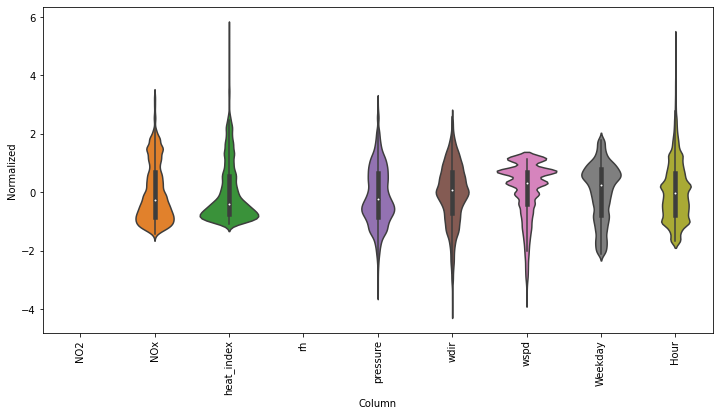

In [90]:
# Visualization of normalized values
df_std = (lstm_df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(lstm_df.keys(), rotation=90)
lstm_df.keys()

In [91]:
# Metric - Mean Absolute Percentage Error suggested by Shengui Li
def smape(y_true, y_pred):
    return mean_absolute_error(y_pred, y_true)
    # return tf.reduce_mean(2 * tf.abs(y_true - y_pred)
    #                      / (tf.abs(y_pred) + tf.abs(y_true)) , axis=-1)

In [92]:
# Group the timestamp dataset into days format
def split_dataset(train,val,test):
    # split into days and restructure into windows of daily data
    train = array(split(train, len(train)/48))
    val = array(split(val, len(val)/48))
    test = array(split(test, len(test)/48))
    return train,val,test


In [93]:
train, val, test = split_dataset(training_set.values,validation_set.values,testing_set.values)
print("Data format: [Samples,Timesteps,Features]")
print('Training data:',train.shape,'\nValidation data:',val.shape,'\nTesting data:',test.shape)

Data format: [Samples,Timesteps,Features]
Training data: (666, 48, 9) 
Validation data: (74, 48, 9) 
Testing data: (82, 48, 9)


In [94]:
# convert history into inputs and outputs format of 24 hours history and 24 hours forecast
def to_supervised(train, n_input=48, n_out=48):
    # flatten data into timestamps data format
    # 507 * 48, 7
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            X.append(data[in_start:in_end, :])
            y.append(data[in_end:out_end, 0:2]) # Change the 2nd dimension according to the num of features to be predicted 
        # move along one time step
        in_start += 1
    return array(X), array(y)

In [95]:
# Build the LSTM model architecture and train the model
def build_model(train,val,n_input,n_out_features):
    
    # prepare the training and validation data by sequencing them as window of 24 hours data 
    train_x, train_y = to_supervised(train, n_input)
    val_x, val_y = to_supervised(val,n_input)
    
    # define the model parameters
    verbose, epochs, batch_size = 2, 30, 128
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    
    # define the model architecture
    model = Sequential()
    
    # # Single feature prediction
    # model.add(LSTM(50, activation='relu',input_shape=(n_timesteps, n_features)))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dense(n_outputs))
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=4,
                                                    mode='min')
    
    # Multi features predictions
    # model.add(LSTM(50, activation='relu',
    #           input_shape=(n_timesteps, n_features)))
    # model.add(Attention(name='attention_weight'))
    # model.add(Dropout(0.50))
    # model.add(Dense(100, activation='relu'))
    # model.add(Dropout(0.50))
    # model.add(Dense(n_outputs*n_out_features))
    # model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))  # Reshape the output layer back into [Timesteps,out_featrs]
    
    #CNN + LSTM
    # model.add(Conv1D(filters=6, kernel_size=2,
    #                  strides=1, 
    #                  padding="same",
    #                  activation="tanh",
    #                  input_shape=[n_timesteps, n_features])),
    # model.add(Conv1D(filters=16, kernel_size=2,
    #                  strides=1,padding="valid",
    #                  activation="tanh"))
    # model.add(AveragePooling1D()),
    
    # model.add(LSTM(50, activation='tanh'))
    # model.add(Attention(name='attention_weight'))
    # model.add(Dropout(0.50))
    # model.add(Dense(100, activation='tanh'))
    # model.add(Dropout(0.50))
    # model.add(Dense(n_outputs*n_out_features))
    # model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))  # Reshape the output layer back into [Timesteps,out_featrs]
    
    #LSTM model
    # model.add(LSTM(25, activation='relu', input_shape=(n_timesteps, n_features)))
    # model.add(Dropout(0.20))
    # model.add(Dense(50, activation='relu'))
    # model.add(Dropout(0.20))
    # model.add((Dense(n_outputs*n_out_features)))
    # model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))

    model.add(LSTM(30, activation='tanh',
              input_shape=(n_timesteps, n_features)))
    # model.add(Dropout(0.3))
    model.add(Dense(15, activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(n_outputs*n_out_features))
    model.add(Dropout(0.3))
    model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))


    
    #GRU
    # model.add(GRU(10, activation='relu', ,
    #          input_shape=(n_timesteps, n_features)))
    # model.add(Dropout(0.3))
    # model.add(Dense(80, activation='relu'))
    # # model.add(Dropout(0.50))
    # model.add(Dense(n_outputs*n_out_features))
    # model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))
    
    #Bi-directional LSTMS
    #model.add(Bidirectional(LSTM(50,return_sequences=True,
    #                       input_shape=(n_timesteps, n_features))))
    #model.add(Dropout(0.50))
    #model.add(Bidirectional(LSTM(50,return_sequences=True)))
    #model.add(Dropout(0.50))
    #model.add(Bidirectional(LSTM(50,return_sequences=True)))
    #model.add(Dropout(0.50))
    #model.add(Bidirectional(LSTM(50,return_sequences=True)))
    #model.add(Dropout(0.50))
    #model.add(TimeDistributed(Dense(n_out_features)))
    #model.add(tf.keras.layers.Reshape([n_outputs, n_out_features]))
    model.compile(loss='mae', optimizer='adam')
    
    # fit the network
    history = model.fit(train_x, train_y, epochs=epochs, 
                        batch_size=batch_size,shuffle=False,
                        validation_data=(val_x, val_y),
                        callbacks=[early_stopping],
                        verbose=verbose)

    # Plot the validation loss and training loss 
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.legend()
    plt.show()

    # Feature importance:
    results = []
    print(' Computing LSTM Feature importance...')
    feature_preds = model.predict(val_x, verbose = 0).squeeze()
    baseline_mae = np.mean(np.abs(feature_preds - val_y))
    results.append({'feature': 'BASELINE', 'mae': baseline_mae})
                                                         
    for i in range(len(columnsTitles)):
        save_col = val_x[:,:,i].copy()
        np.random.shuffle(val_x[:,:,i])

        feature_preds = model.predict(val_x, verbose = 0).squeeze()
        mae = np.mean(np.abs(feature_preds - val_y))
        results.append({'feature': columnsTitles[i], 'mae': mae})
        val_x[:,:,i] = save_col
    
    print()
    width = [0.2]
    df = pd.DataFrame(results)
    df = df.sort_values('mae')
    plt.figure(figsize=(5,5))
    plt.barh(np.arange(len(columnsTitles)+1),df.mae, width)
    plt.yticks(np.arange(len(columnsTitles)+1),df.feature.values)
    plt.title('LSTM Feature Importance',size=16)
    plt.ylim((-1,len(columnsTitles)+1))
    plt.plot([baseline_mae,baseline_mae],[-1,len(columnsTitles)+1], '--', color='orange',
                     label=f'Baseline \nMAE={baseline_mae:.3f}')
    plt.xlabel('MAE with feature permuted',size=14)
    plt.ylabel('Feature',size=14)
    plt.legend()
    plt.show()
    
    return model

In [96]:
# Make a forecast for next 24 hours
def forecast(model, history, n_input):
    # flatten the data into timestamps format
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    
    # retrieve last observations i.e last 24 hours for input data 
    input_x = data[-n_input:, :]
    
    # reshape into [1, n_input, 1]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1]))
    
    # forecast the next day
    yhat = model.predict(input_x, verbose=2)
    model.save('tf_lstm_model.h5')  
    return yhat[0]

In [97]:
# Evaluate the model
def evaluate_model(train,val,test, n_input,n_out_features):
    # fit model
    model = build_model(train,val,n_input,n_out_features)
    model.summary()
    # history is a list of daily data
    history = [x for x in val] #train]
    # walk-forward validation over each day  
    predictions = list()
    for i in range(len(test)):
        # predict the next day
        yhat_sequence = forecast(model, history, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next day
        history.append(test[i, :])
    # evaluate predictions days for each day
    predictions = array(predictions)
    return predictions

Epoch 1/30
250/250 - 5s - loss: 0.7488 - val_loss: 0.7443
Epoch 2/30
250/250 - 4s - loss: 0.6927 - val_loss: 0.6723
Epoch 3/30
250/250 - 5s - loss: 0.6704 - val_loss: 0.6524
Epoch 4/30
250/250 - 5s - loss: 0.6616 - val_loss: 0.6444
Epoch 5/30
250/250 - 4s - loss: 0.6548 - val_loss: 0.6397
Epoch 6/30
250/250 - 4s - loss: 0.6510 - val_loss: 0.6373
Epoch 7/30
250/250 - 4s - loss: 0.6473 - val_loss: 0.6329
Epoch 8/30
250/250 - 5s - loss: 0.6434 - val_loss: 0.6306
Epoch 9/30
250/250 - 4s - loss: 0.6405 - val_loss: 0.6246
Epoch 10/30
250/250 - 4s - loss: 0.6373 - val_loss: 0.6225
Epoch 11/30
250/250 - 4s - loss: 0.6358 - val_loss: 0.6198
Epoch 12/30
250/250 - 5s - loss: 0.6334 - val_loss: 0.6187
Epoch 13/30
250/250 - 4s - loss: 0.6316 - val_loss: 0.6176
Epoch 14/30
250/250 - 5s - loss: 0.6305 - val_loss: 0.6191
Epoch 15/30
250/250 - 4s - loss: 0.6285 - val_loss: 0.6191
Epoch 16/30
250/250 - 4s - loss: 0.6269 - val_loss: 0.6183
Epoch 17/30
250/250 - 4s - loss: 0.6267 - val_loss: 0.6214


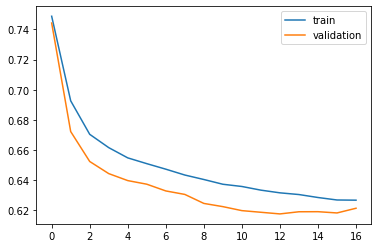

 Computing LSTM Feature importance...



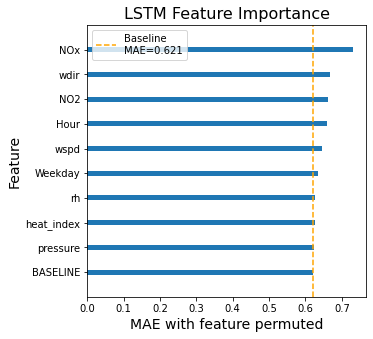

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 30)                4800      
_________________________________________________________________
dense_8 (Dense)              (None, 15)                465       
_________________________________________________________________
dropout_8 (Dropout)          (None, 15)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 96)                1536      
_________________________________________________________________
dropout_9 (Dropout)          (None, 96)                0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 48, 2)             0         
Total params: 6,801
Trainable params: 6,801
Non-trainable params: 0
____________________________________________________

In [98]:
# Main program starts from here - Firstly split the timestamp data into days format
train, val, test = split_dataset(training_set.values,validation_set.values,testing_set.values)

n_input = 48   # Number of previous timestamps needed to predict future data
n_out_features = 2  # features to be predicted [NO2,NOX as NO2, PM10 and PM2.5]

predictions = evaluate_model(train,val,test, n_input,n_out_features)

In [99]:
predictions.shape

(82, 48, 2)

# Collect the predicted values for the 2 pollutants, denormalize the values and calculate the SMAPE scores

In [100]:
# # print(predictions.shape)
# from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error 
# # Predictions for NO2, NOX as NO2, PM10 and PM2.5

# pred_de_norm = {}
# grnd_de_norm = {}
# smape_scores = {}
# avg_smape_score = 0 

# df_write = pd.DataFrame(columns=['NO2','NOX'])
# df_write1 = pd.DataFrame(columns=['NO2','NOX'])

# n_out = 48
# for i in range(0,2):
    
#     # Denormalize the predicted values
#     #pred_de_norm[i] = ( predictions[:,:,i] * train_std[i] ) + train_mean[i]
#     #grnd_de_norm[i] = ( test[:,:n_out,i] * train_std[i] ) + train_mean[i]
    
#     pred_de_norm[i] = predictions[:,:,i]
#     grnd_de_norm[i] = test[:,:n_out,i]
    
#     # Reshape into 1D array
#     grnd_de_norm[i] = grnd_de_norm[i].reshape(grnd_de_norm[i].shape[0]*grnd_de_norm[i].shape[1])
#     pred_de_norm[i] = pred_de_norm[i].reshape(pred_de_norm[i].shape[0]*pred_de_norm[i].shape[1])

#     pred_de_norm[i] = pred_de_norm[i].astype('float32')
#     grnd_de_norm[i] = grnd_de_norm[i].astype('float32')
    
#     #smape_scores[i] = smape(grnd_de_norm[i],pred_de_norm[i])
#     smape_scores[i] = mean_absolute_error(grnd_de_norm[i],pred_de_norm[i]) 
    
#     avg_smape_score = avg_smape_score + smape_scores[i]
    
#     col = df_write.columns[i]
#     col1 = df_write1.columns[i]

#     df_write[col] = pred_de_norm[i]
#     df_write1[col1] = grnd_de_norm[i]
    
# #df_write.insert(loc=0, column='Start', value=date_time[41616:].values)
# avg_smape_score = avg_smape_score / 2
# print("\nSmape score for all 2 pollutants:",smape_scores)
# print("\nAverage smape score:",avg_smape_score)

In [101]:
# print(predictions.shape)
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error 
# Predictions for NO2, NOX as NO2, PM10 and PM2.5

pred_de_norm = {}
grnd_de_norm = {}
pred_norm = {}
grnd_norm = {}
mae_scores = {}
avg_mae_score = 0 

df_write = pd.DataFrame(columns=['NO2','NOX'])
df_write1 = pd.DataFrame(columns=['NO2','NOX'])

n_out = 48
for i in range(0,2):
    
    # Denormalize the predicted values
    pred_norm[i] = ( predictions[:,:,i] * train_std[i] ) + train_mean[i]
    grnd_norm[i] = ( test[:,:n_out,i] * train_std[i] ) + train_mean[i]
    
    pred_de_norm[i] = predictions[:,:,i]
    grnd_de_norm[i] = test[:,:n_out,i]
    
    # Reshape into 1D array for normal values
    grnd_norm[i] = grnd_norm[i].reshape(grnd_norm[i].shape[0]*grnd_norm[i].shape[1])
    pred_norm[i] = pred_norm[i].reshape(pred_norm[i].shape[0]*pred_norm[i].shape[1])

    pred_norm[i] = pred_norm[i].astype('float32')
    grnd_norm[i] = grnd_norm[i].astype('float32')
    
    # Reshape into 1D array
    grnd_de_norm[i] = grnd_de_norm[i].reshape(grnd_de_norm[i].shape[0]*grnd_de_norm[i].shape[1])
    pred_de_norm[i] = pred_de_norm[i].reshape(pred_de_norm[i].shape[0]*pred_de_norm[i].shape[1])

    pred_de_norm[i] = pred_de_norm[i].astype('float32')
    grnd_de_norm[i] = grnd_de_norm[i].astype('float32')
    
    #smape_scores[i] = smape(grnd_de_norm[i],pred_de_norm[i])
    mae_scores[i] = mean_absolute_error(grnd_norm[i],pred_norm[i]) 
    
    avg_mae_score = avg_mae_score + mae_scores[i]
    
    col = df_write.columns[i]
    col1 = df_write1.columns[i]

    df_write[col] = pred_norm[i]
    df_write1[col1] = grnd_norm[i]
    
#df_write.insert(loc=0, column='Start', value=date_time[41616:].values)
avg_mae_score = avg_mae_score / 2
print("\nMAE score for all 2 pollutants:",mae_scores)
print("\nAverage MAE score:",avg_mae_score)



MAE score for all 2 pollutants: {0: 6.9295645, 1: 16.00212}

Average MAE score: 11.46584177017212


In [102]:
# model.save('tf_lstm_model.h5')

In [103]:
# Write the predicted values to a CSV file 
df_write.to_csv(r'Aalborg_Gade_Predicted_output.csv')
df_write1.to_csv(r'Aalborg_Gade_Real_output.csv')

# Plots for predicted and real values

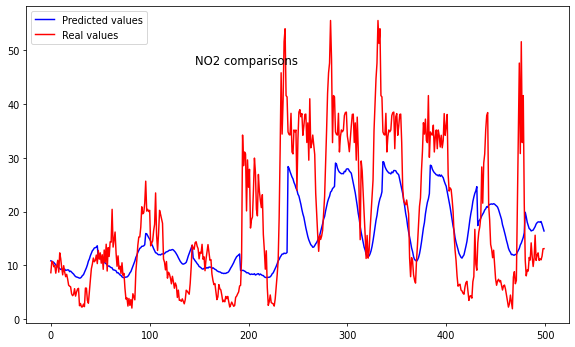

In [107]:
plt.figure(num=None, dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(pred_norm[0][0:500], "-b", label="Predicted values")
plt.plot(grnd_norm[0][0:500], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NO2 comparisons', x=0.5, y=0.8, loc='right')
plt.show()

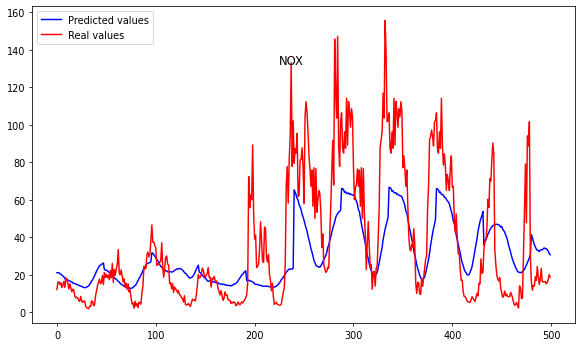

In [108]:
plt.figure(num=None, dpi=70, figsize=(10, 6),facecolor='w', edgecolor='k')
plt.plot(pred_norm[1][0:500], "-b", label="Predicted values")
plt.plot(grnd_norm[1][0:500], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('NOX', x=0.5, y=0.8, loc='right')
plt.show()

In [106]:
plt.figure(num=None, dpi=70, figsize=(20, 6),facecolor='w', edgecolor='k')
plt.plot(pred_de_norm[2], "-b", label="Predicted values")
plt.plot(grnd_de_norm[2], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('PM10 comparisons', y=0.5, loc='right')
plt.show()

KeyError: 2

<Figure size 1400x420 with 0 Axes>

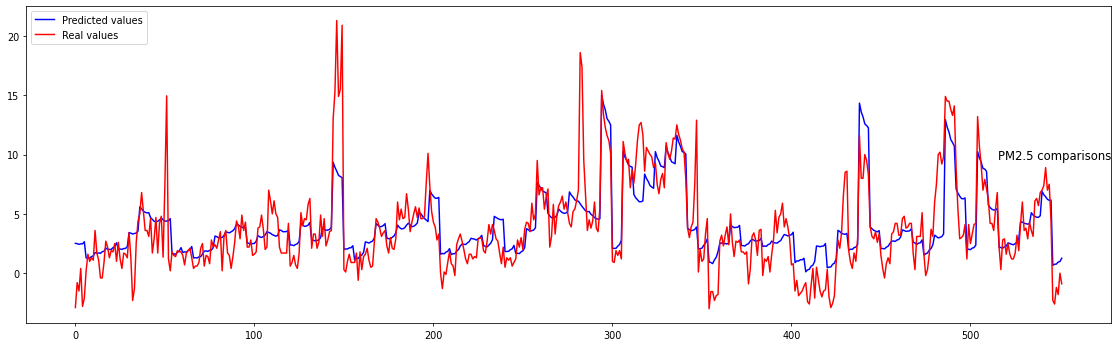

In [ ]:
plt.figure(num=None, dpi=70, figsize=(20, 6),facecolor='w', edgecolor='k')
plt.plot(pred_de_norm[3], "-b", label="Predicted values")
plt.plot(grnd_de_norm[3], "-r", label="Real values")
plt.legend(loc="upper left")
plt.title('PM2.5 comparisons', y=0.5, loc='right')
plt.show()